In [1]:
import numpy as np
import autograd
import matplotlib.pyplot as plt

In [2]:
n_agent = 3
horizon = 15
checkpionts = np.array([[0.0, 20.0], [20.0, 20.0], [20., 0.0]])
n_check_points = checkpionts.shape[0]
keep_dist = np.array([[1.0,1.0], [-1.0,1.0]])
X_init = np.zeros((n_agent, horizon*4))  # [Xx, Xy, Vx, Vy] -> (n_agents, 20)
internal_MUE_init = np.ones((n_agent, horizon*2))  # [Vx, Vy] -> (n_agents, 10)
shared_MUE_init = np.ones((n_agent-1, horizon*2))  # [coordx, coordy] -> (n_agents-1, 10) 
rho = 0.1
x0 = np.array([0.0, -1.0, 1.0])
y0 = np.array([1.0, 0.0 ,0.0])
dt = 1.0

In [3]:
def f_cost(X, n):
    U = X[horizon*2:]
    X = X[:horizon*2]
    if n==0:
        diff = 0.0
        for i in range(n_check_points):
            diff = diff+ np.abs(X[horizon-1-horizon//n_check_points*i]-checkpionts[n_check_points-i-1][0])**2 # mid point of x
            diff = diff + np.abs(X[2*horizon-1-horizon//n_check_points*i]-checkpionts[n_check_points-i-1][1])**2 # mid point of y
    else:
        diff = 0.0
    
    return diff*10 + np.linalg.norm(U, axis=0)**2/10

In [4]:
def compute_gradient(X, mue_sh, f_for_grad, n):
    N_dim = X.shape[0]
    gradient_vector = np.zeros_like(X)
    h = 1e-3
    for i in range(N_dim):
        x_plus_h = X.copy()
        x_plus_h[i] += h

        x_minus_h = X.copy()
        x_minus_h[i] -= h

        gradient_vector[i] = (
            f_for_grad(x_plus_h[: horizon * 4], x_plus_h[horizon * 4 :], mue_sh, n=n)
            
            - f_for_grad(x_minus_h[: horizon * 4], x_minus_h[horizon * 4 :], mue_sh, n=n)) / (2 * h)
    return gradient_vector

In [5]:
def rotation_matrix(dists, x_vec, y_vec):
    vec = np.array([x_vec, y_vec])
    theta = np.arctan(vec[1]/(vec[0]+1e-9)) -np.pi/2
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    rotated = R@dists
    return rotated

In [6]:
def Lagrangian(*X_and_MUEs, n):
    X, internal_MUE, shared_MUE = X_and_MUEs
    f_term = f_cost(X, n)
    lagrange_term = 0.0
    
    # initianl internal constraints
    lagrange_term = lagrange_term + internal_MUE[0]*(X[0] - x0[n] - X[horizon*2] * dt)
    lagrange_term = lagrange_term + internal_MUE[horizon]*(X[horizon] - y0[n] - X[horizon*3] * dt)
    
    augmented_term = 0.0
    augmented_term = augmented_term + (X[0] - x0[n] - X[horizon*2] * dt)**2
    augmented_term = augmented_term + (X[horizon] - y0[n] - X[horizon*3] * dt)**2
    
    for i in range(1,horizon): #internal constraints
            
        lagrange_term = lagrange_term + internal_MUE[i]*(X[i] - X[i-1] - X[horizon*2+i] * dt)  # x_i = x_{i-1} + v_i*dt
        lagrange_term = lagrange_term + internal_MUE[i+horizon]*(X[i+horizon] - X[i+horizon-1] - X[horizon*3+i] * dt)  # y_i = y_{i-1} + vi*dt
        
        augmented_term = augmented_term + (X[i] - X[i-1] - X[horizon*2+i] * dt)**2
        augmented_term = augmented_term + (X[i+horizon] - X[i+horizon-1] - X[horizon*3+i] * dt)**2        
    for i in range(horizon): # shared constraints
        
        if n != 0:
            lagrange_term = lagrange_term + shared_MUE[n-1][i]*X[i]
            lagrange_term = lagrange_term + shared_MUE[n-1][i+horizon]*X[i+horizon]
            
        else:
            lagrange_term = lagrange_term - shared_MUE.sum(axis=0)[i]*X[i]
            lagrange_term = lagrange_term - shared_MUE.sum(axis=0)[i+horizon]*X[i+horizon]
            
        for j in range(n_agent-1):
            rotated_dist = rotation_matrix(keep_dist[j], X_current[0][horizon*2+i], X_current[0][horizon*3+i]) #rotate distances based on head agent velocity 
            augmented_term = augmented_term + (X_current[j+1][i]         - X_current[0][i]         + rotated_dist[0])**2    
            augmented_term = augmented_term +(X_current[j+1][i+horizon] - X_current[0][i+horizon] + rotated_dist[1])**2    
    return lagrange_term + f_term + rho*augmented_term/2/n_agent

In [7]:
def get_grad_shared_mue(X,shared_mue):
    
    grad = np.zeros_like(shared_mue)
    
    for i in range(n_agent-1):
        for j in range(horizon):
            rotated_dist = rotation_matrix(keep_dist[i], X[0][horizon*2+j], X[0][horizon*3+j]) # rotate distances based on head agent velocity 
            grad[i][j]         =  X[i+1][j]         - X[0][j]         + rotated_dist[0]    # x
            grad[i][j+horizon] =  X[i+1][j+horizon] - X[0][j+horizon] + rotated_dist[1]    # y
                      
    return grad
            

In [8]:
X_values = [X_init]
X_current = X_values[-1] # shape(n_agent, horizon*4)
f_values = [f_cost(X_current[-1], 0)]

MUE_in_values = [internal_MUE_init]
MUE_sh_values = [shared_MUE_init]
MUE_sh_current = MUE_sh_values[-1].copy()
MUE_in_current = MUE_in_values[-1].copy()
lagrange_values = [Lagrangian(X_current[0], MUE_in_current[0], MUE_sh_current, n=0)]

for i in range(10000):  #update shared mue
    for n in range(n_agent): # for each agent
        grad_input_for_Lagrangian = np.concatenate((X_current[n], MUE_in_current[n]))
        gradient_vector = compute_gradient(grad_input_for_Lagrangian, MUE_sh_current, Lagrangian, n=n)
        X_current[n] = X_current[n] - 0.05*gradient_vector[:horizon*4] #update X
            
            # X_current[horizon*2:] = np.minimum(X_current[horizon*2:], [max_U]*10)
            # X_current[horizon*2:] = np.maximum(X_current[horizon*2:], [-max_U]*10)
            
        grad_input_for_Lagrangian = np.concatenate((X_current[n], MUE_in_current[n]))
        gradient_vector = compute_gradient(grad_input_for_Lagrangian, MUE_sh_current, Lagrangian, n=n)
        MUE_in_current[n] = MUE_in_current[n] + 0.05*rho*gradient_vector[horizon*4:] #update internal MUE 
        
    MUE_sh_current = MUE_sh_current + 0.05*rho*get_grad_shared_mue(X_current, MUE_sh_current) #update shared MUE 
        
        
        
    
    X_values.append(X_current.copy())
    f_values.append(f_cost(X_current[n],n))
    MUE_sh_values.append(MUE_sh_current.copy())
    MUE_in_values.append(MUE_in_current.copy())
    # lagrange_values.append(Lagrangian(X_current, MUE_current))


Text(0.5, 0, 'iterations')

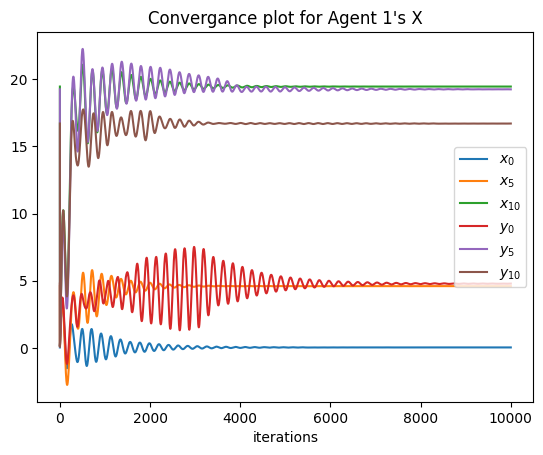

In [9]:
aa = np.array(X_values)
plt.title("Convergance plot for Agent 1's X")
selected = np.array([0,1,2,3,4,5])*horizon//3
plt.plot(aa[:,0,selected]);
plt.legend(['$x_0$','$x_5$','$x_{10}$','$y_0$','$y_5$','$y_{10}$'], loc=7)
plt.xlabel("iterations")

In [10]:
n_th = 1
X_show = np.round(X_current, 1)
print(f'Path and velocity of agent {n_th+1}')
print('X: ', X_show[n_th][:horizon])
print('Vx: ', X_show[n_th][horizon*2:horizon*3])
print('Y: ', X_show[n_th][horizon:horizon*2])
print('Vy: ', X_show[n_th][-horizon:])

Path and velocity of agent 2
X:  [-1.  -1.  -0.9 -0.9 -0.9  3.7  7.4 11.2 15.  18.9 18.3 20.5 20.7 20.8
 21. ]
Vx:  [ 0.1  0.1  0.1  0.1  0.1  4.7  3.7  3.9  3.8  3.9 -0.5  2.2  0.2  0.2
  0.2]
Y:  [ 3.8  7.5 11.3 15.1 18.9 20.4 20.4 20.6 20.7 20.8 15.8 12.5  8.7  4.9
  1.1]
Vy:  [ 3.7  3.7  3.7  3.7  3.7  1.5  0.   0.1  0.1  0.1 -5.  -3.3 -3.8 -3.8
 -3.8]


Text(0.5, 0, 'iterations')

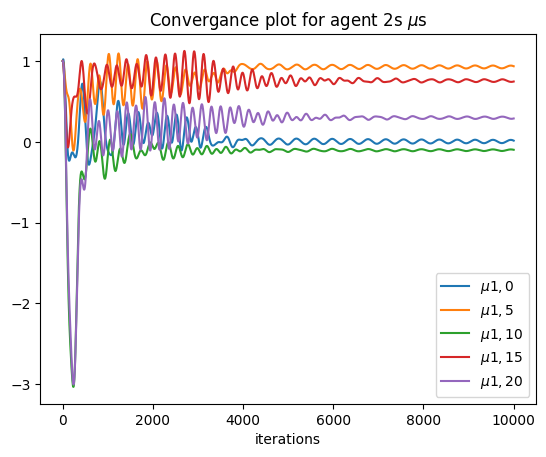

In [11]:
selected = np.array([0,1,2,3,4])*horizon//3
plt.plot(np.array(MUE_in_values)[:,1,selected]);
plt.title("Convergance plot for agent 2s $\mu$s")
plt.legend(['$\mu{1,0}$','$\mu{1,5}$','$\mu{1,10}$','$\mu{1,15}$','$\mu{1,20}$'])
plt.xlabel("iterations")

Text(0.5, 0, 'iterations')

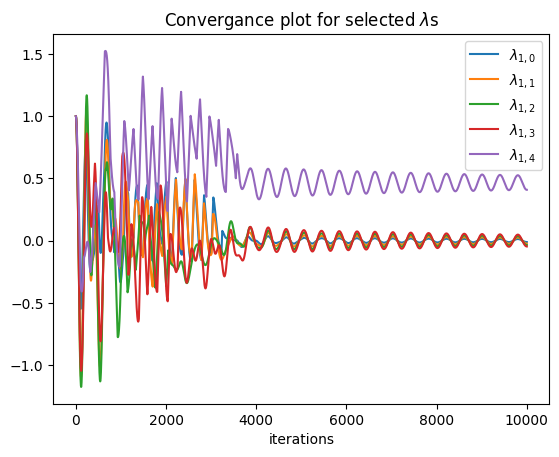

In [12]:
plt.plot(np.array(MUE_sh_values)[:,1,:horizon//3]);
plt.title("Convergance plot for selected $\lambda$s")
plt.legend(['$\lambda_{1,0}$','$\lambda_{1,1}$','$\lambda_{1,2}$','$\lambda_{1,3}$','$\lambda_{1,4}$'])
plt.xlabel("iterations")

Text(0, 0.5, 'Y')

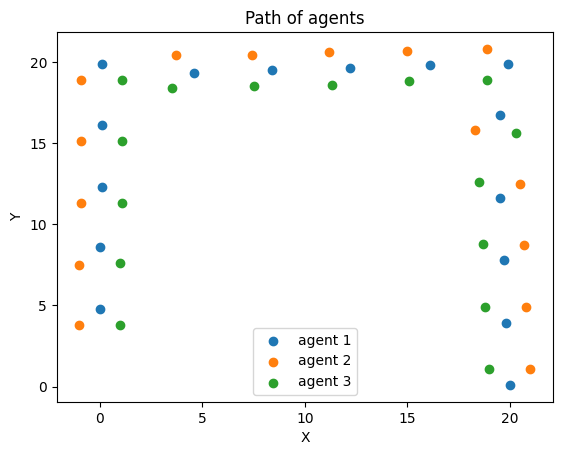

In [13]:
for i in range(n_agent): 
    plt.scatter(X_show[i][:horizon], X_show[i][horizon:horizon*2], label=f'agent {i+1}');
    
plt.title("Path of agents")
plt.legend(loc=8)
plt.xlabel("X")
plt.ylabel("Y")